In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
usage = pd.read_csv("../data/raw/usage_reports.csv")
rates = pd.read_csv("../data/raw/royalty_rates.csv")
payments = pd.read_csv("../data/raw/payments.csv")
artists = pd.read_csv("../data/raw/artist_lookup.csv")
usage.head()

,usage_report_id,report_month,platform,territory,track_id,isrc,track_title,artist_id,artist_name,release_date,stream_type,streams,unique_listeners,avg_stream_seconds,reported_currency
0,UR20000001,2023-07,Spotify,FR,10362,ISRC4538002,No Signal,AR0016,Indigo Santos,2019-08-22,free,950,333,232.322142,EUR
1,UR20000002,2023-10,Amazon Music,GB,10536,ISRC1936197,Neon Dreams,AR0025,Kai Atlas,2020-06-27,free,656,124,174.848842,GBP
2,UR20000003,2023-11,Apple Music,GB,11095,ISRC3578005,Neon Dreams,AR0052,Nico Koi,2017-06-18,free,1698,418,184.835507,GBP
3,UR20000004,2023-09,YouTube Music,CA,10478,ISRC4030872,Afterglow,AR0021,Iris Stone & The Collective,2021-06-20,premium,1442,270,206.766053,CAD
4,UR20000005,2025-12,Apple Music,CA,11135,ISRC1204488,City Lights (Edit),AR0055,Nico Ryder Jr.,2024-03-15,premium,4760,1581,154.728930,CAD


In [5]:
usage['artist_name'].value_counts()

artist_name
Theo Vega       2815
Nico Stone      2779
Sage Atlas      2763
Indigo Blaze    2761
Kai Blaze       2753
                ... 
Mila Reign       652
Jade Atlas       649
Kai Sol          648
Theo Haze        644
Mila Vega        640
Name: count, Length: 100, dtype: int64

In [6]:
print("Usage rows:", len(usage))
print("Rates rows:", len(rates))
print("Payments rows:", len(payments))

print("\nMissing ISRCs:", usage["isrc"].isna().sum())
print("Negative streams:", (usage["streams"] < 0).sum())
print("Zero streams:", (usage["streams"] == 0).sum())

Usage rows: 120000
Rates rows: 180
Payments rows: 108000

Missing ISRCs: 4747
Negative streams: 1142
Zero streams: 2310


In [7]:
usage["platform"] = usage["platform"].astype(str).str.strip()
usage["platform"] = usage["platform"].str.title().replace({"Youtube Music": "YouTube Music"})

usage["territory"] = usage["territory"].astype(str).str.strip().str.upper()

In [8]:
usage["artist_name"].value_counts().head(15)


artist_name
Theo Vega                       2815
Nico Stone                      2779
Sage Atlas                      2763
Indigo Blaze                    2761
Kai Blaze                       2753
Phoenix Santos                  2733
Avery Reign                     2721
Aria Bloom & The Collective     2706
Iris Santos & The Collective    2706
Nico Sparks                     2701
Zion Stone                      2700
Rowan Blaze                     2670
Mila Haze & The Collective      1433
Indigo Stone                    1431
Nico Atlas                      1394
Name: count, dtype: int64

In [9]:
ARTIST = "Phoenix Santos"  
artist_usage = usage[usage["artist_name"] == ARTIST].copy()

print("Rows for artist:", len(artist_usage))
artist_usage.head()

Rows for artist: 2733


,usage_report_id,report_month,platform,territory,track_id,isrc,track_title,artist_id,artist_name,release_date,stream_type,streams,unique_listeners,avg_stream_seconds,reported_currency
74,UR20000075,2023-11,YouTube Music,FR,11321,ISRC5800967,Parallel Lines,AR0063,Phoenix Santos,2020-08-10,premium,4409,1499,246.994531,EUR
222,UR20000223,2023-03,Amazon Music,GB,11317,ISRC4716504,Midnight Run,AR0063,Phoenix Santos,2018-12-29,premium,6234,1191,120.670841,GBP
287,UR20000288,2023-04,Apple Music,SE,11306,ISRC8330200,Gravity,AR0063,Phoenix Santos,2020-09-26,premium,9223,2904,176.753928,SEK
300,UR20000301,2024-02,YouTube Music,US,11319,ISRC3303424,Blue Notes,AR0063,Phoenix Santos,2023-11-15,free,13473,3199,135.366225,USD
408,UR20000409,2025-03,Spotify,CA,11313,ISRC6252077,Neon Dreams (Remix),AR0063,Phoenix Santos,2021-06-04,premium,7342,2210,120.504018,CAD


joining artist usage and rate ro calculate revenue

In [15]:
# Clean both tables the same way (important)
artist_usage["platform"] = artist_usage["platform"].astype(str).str.strip()
artist_usage["platform"] = artist_usage["platform"].str.title().replace({"Youtube Music": "YouTube Music"})
artist_usage["territory"] = artist_usage["territory"].astype(str).str.strip().str.upper()

rates_clean = rates.copy()
rates_clean["platform"] = rates_clean["platform"].astype(str).str.strip()
rates_clean["platform"] = rates_clean["platform"].str.title().replace({"Youtube Music": "YouTube Music"})
rates_clean["territory"] = rates_clean["territory"].astype(str).str.strip().str.upper()

# Merge rates onto usage
artist_usage = artist_usage.merge(
    rates_clean[["platform", "stream_type", "territory", "rate_per_stream"]],
    on=["platform", "stream_type", "territory"],
    how="left"
)

# Quick check
print("Missing rate_per_stream:", artist_usage["rate_per_stream"].isna().mean())
artist_usage[["platform", "stream_type", "territory", "rate_per_stream"]].head()


Missing rate_per_stream: 0.0


,platform,stream_type,territory,rate_per_stream
0,YouTube Music,premium,FR,0.00187
1,Amazon Music,premium,GB,0.00452
2,Apple Music,premium,SE,0.00172
3,YouTube Music,free,US,0.00203
4,Spotify,premium,CA,0.00512


ignoring negative streams by clipping at 0

In [16]:
artist_usage.columns


Index(['usage_report_id', 'report_month', 'platform', 'territory', 'track_id',
       'isrc', 'track_title', 'artist_id', 'artist_name', 'release_date',
       'stream_type', 'streams', 'unique_listeners', 'avg_stream_seconds',
       'reported_currency', 'rate_per_stream_x', 'rate_per_stream_y',
       'streams_clean', 'rate_per_stream'],
      dtype='object')

In [17]:
artist_usage.head()

,usage_report_id,report_month,platform,territory,track_id,isrc,track_title,artist_id,artist_name,release_date,stream_type,streams,unique_listeners,avg_stream_seconds,reported_currency,rate_per_stream_x,rate_per_stream_y,streams_clean,rate_per_stream
0,UR20000075,2023-11,YouTube Music,FR,11321,ISRC5800967,Parallel Lines,AR0063,Phoenix Santos,2020-08-10,premium,4409,1499,246.994531,EUR,0.00187,0.00187,4409,0.00187
1,UR20000223,2023-03,Amazon Music,GB,11317,ISRC4716504,Midnight Run,AR0063,Phoenix Santos,2018-12-29,premium,6234,1191,120.670841,GBP,0.00452,0.00452,6234,0.00452
2,UR20000288,2023-04,Apple Music,SE,11306,ISRC8330200,Gravity,AR0063,Phoenix Santos,2020-09-26,premium,9223,2904,176.753928,SEK,0.00172,0.00172,9223,0.00172
3,UR20000301,2024-02,YouTube Music,US,11319,ISRC3303424,Blue Notes,AR0063,Phoenix Santos,2023-11-15,free,13473,3199,135.366225,USD,0.00203,0.00203,13473,0.00203
4,UR20000409,2025-03,Spotify,CA,11313,ISRC6252077,Neon Dreams (Remix),AR0063,Phoenix Santos,2021-06-04,premium,7342,2210,120.504018,CAD,0.00512,0.00512,7342,0.00512


In [18]:
artist_usage["streams_clean"] = artist_usage["streams"].clip(lower=0)
artist_usage["expected_revenue"] = artist_usage["streams_clean"] * artist_usage["rate_per_stream"]

artist_usage[["report_month", "platform", "territory", "stream_type", "streams", "streams_clean", "rate_per_stream", "expected_revenue"]].head()

,report_month,platform,territory,stream_type,streams,streams_clean,rate_per_stream,expected_revenue
0,2023-11,YouTube Music,FR,premium,4409,4409,0.00187,8.24483
1,2023-03,Amazon Music,GB,premium,6234,6234,0.00452,28.17768
2,2023-04,Apple Music,SE,premium,9223,9223,0.00172,15.86356
3,2024-02,YouTube Music,US,free,13473,13473,0.00203,27.35019
4,2025-03,Spotify,CA,premium,7342,7342,0.00512,37.59104


In [20]:
artist_usage = artist_usage.copy()  # freezes current state after fixing rate_per_stream


# Build Monthly revenue time series

In [21]:
monthly_revenue = (
    artist_usage.groupby("report_month")["expected_revenue"]
    .sum()
    .reset_index()
)

monthly_revenue["report_month"] = pd.to_datetime(monthly_revenue["report_month"])
monthly_revenue = monthly_revenue.sort_values("report_month")

monthly_revenue.head()

,report_month,expected_revenue
0,2023-01-01,1554.09071
1,2023-02-01,1559.63793
2,2023-03-01,1690.09475
3,2023-04-01,1829.94220
4,2023-05-01,2010.51360


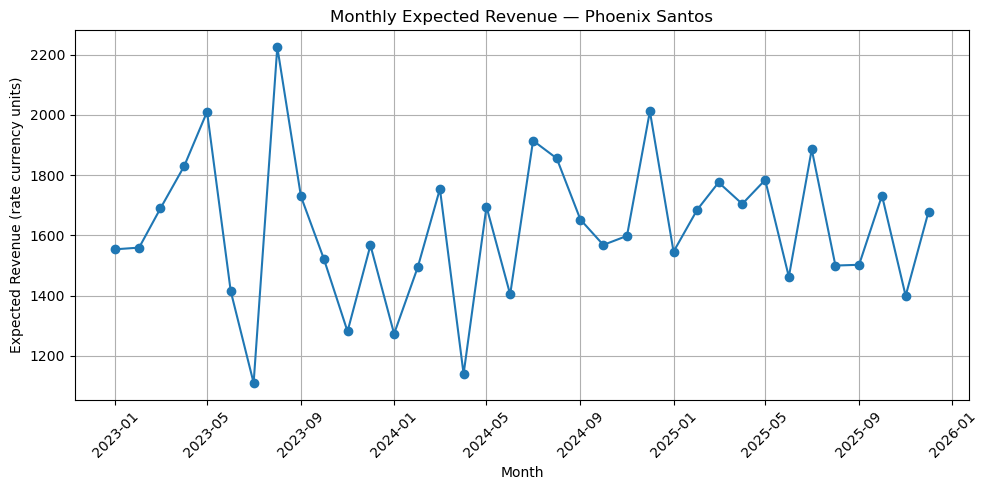

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue["report_month"], monthly_revenue["expected_revenue"], marker="o")
plt.title(f"Monthly Expected Revenue — {ARTIST}")
plt.xlabel("Month")
plt.ylabel("Expected Revenue (rate currency units)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Where does this artist rank among the 100 artists in this data

In [23]:
artist_totals = (
    usage.assign(streams_clean=usage["streams"].clip(lower=0))
    .groupby("artist_name")["streams_clean"]
    .sum()
    .sort_values(ascending=False)
)

rank = int(artist_totals.index.get_loc(ARTIST) + 1)
print(f"{ARTIST} stream rank: {rank} out of {len(artist_totals)} artists")

artist_totals.head(10)


Phoenix Santos stream rank: 7 out of 100 artists


artist_name
Rowan Blaze                    24991180
Theo Vega                      22983745
Indigo Blaze                   22229803
Avery Reign                    21117714
Nico Sparks                    20014325
Zion Stone                     19766251
Phoenix Santos                 18440370
Aria Bloom & The Collective    18101517
Kai Blaze                      17518162
Nico Stone                     16967227
Name: streams_clean, dtype: int64

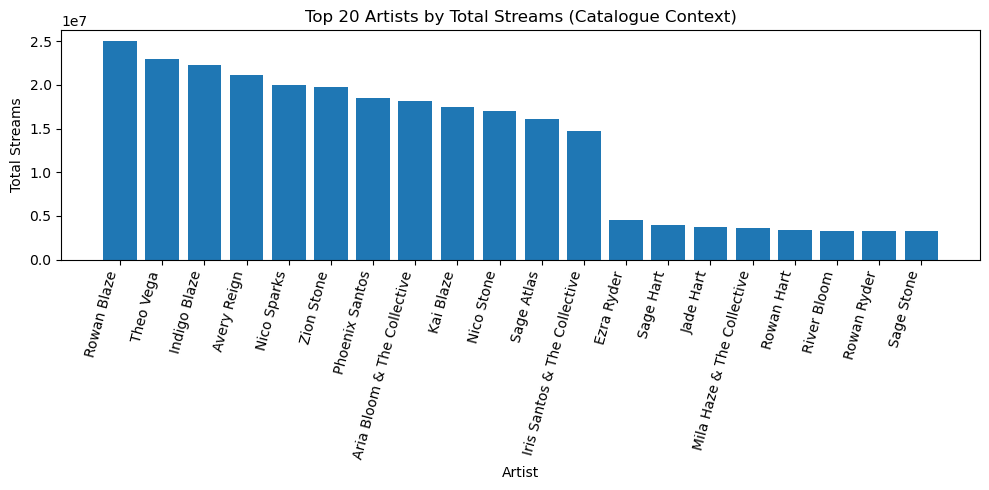

In [24]:
top20 = artist_totals.head(20)

plt.figure(figsize=(10, 5))
plt.bar(top20.index, top20.values)
plt.title("Top 20 Artists by Total Streams (Catalogue Context)")
plt.xlabel("Artist")
plt.ylabel("Total Streams")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


In [25]:
ts = monthly_revenue.set_index("report_month")["expected_revenue"]
ts.head()

report_month
2023-01-01    1554.09071
2023-02-01    1559.63793
2023-03-01    1690.09475
2023-04-01    1829.94220
2023-05-01    2010.51360
Name: expected_revenue, dtype: float64

### Method 1: Naive baseline

#### Idea: “Next month ≈ last month”

This is the simplest possible forecast — and a very important benchmark.

In [26]:
last_value = ts.iloc[-1]

naive_forecast = pd.Series(
    [last_value] * 6,
    index=pd.date_range(
        start=ts.index.max() + pd.offsets.MonthBegin(1),
        periods=6,
        freq="MS"
    )
)

naive_forecast

2026-01-01    1679.37245
2026-02-01    1679.37245
2026-03-01    1679.37245
2026-04-01    1679.37245
2026-05-01    1679.37245
2026-06-01    1679.37245
Freq: MS, dtype: float64

### Method 2: Rolling average

#### Idea: “Smooth out spikes to estimate a typical month”

In [27]:
rolling_mean = ts.rolling(window=3).mean()
rolling_last = rolling_mean.iloc[-1]

rolling_forecast = pd.Series(
    [rolling_last] * 6,
    index=naive_forecast.index
)

rolling_forecast

2026-01-01    1603.83833
2026-02-01    1603.83833
2026-03-01    1603.83833
2026-04-01    1603.83833
2026-05-01    1603.83833
2026-06-01    1603.83833
Freq: MS, dtype: float64

### Method 3: Trend projection

#### Idea: “Is there an overall upward or downward direction?”

In [28]:
x = np.arange(len(ts))
coef = np.polyfit(x, ts.values, 1)  # linear trend
trend = np.poly1d(coef)

future_x = np.arange(len(ts), len(ts) + 6)
trend_forecast = pd.Series(
    trend(future_x),
    index=naive_forecast.index
)

trend_forecast

2026-01-01    1646.280886
2026-02-01    1647.400832
2026-03-01    1648.520777
2026-04-01    1649.640723
2026-05-01    1650.760669
2026-06-01    1651.880615
Freq: MS, dtype: float64

### Compare all forecasts visually

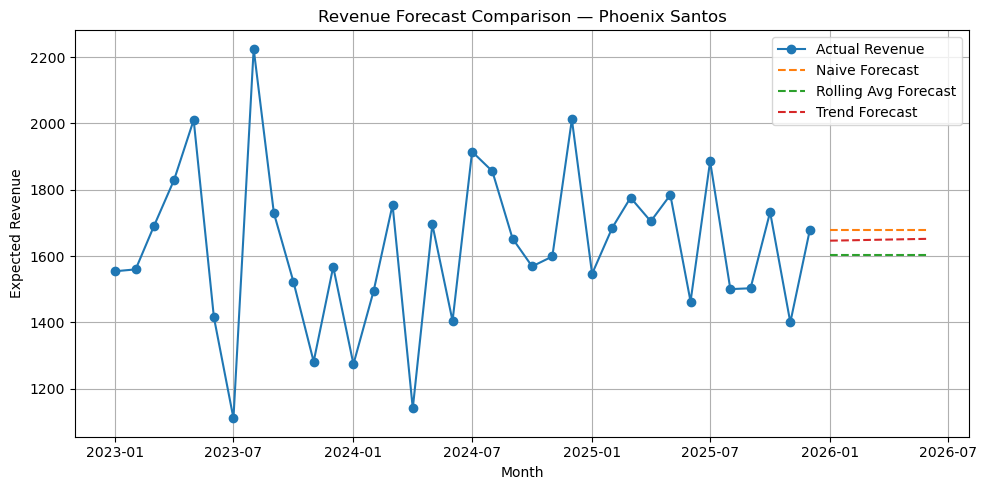

In [29]:
plt.figure(figsize=(10, 5))

plt.plot(ts.index, ts.values, label="Actual Revenue", marker="o")
plt.plot(naive_forecast.index, naive_forecast.values, label="Naive Forecast", linestyle="--")
plt.plot(rolling_forecast.index, rolling_forecast.values, label="Rolling Avg Forecast", linestyle="--")
plt.plot(trend_forecast.index, trend_forecast.values, label="Trend Forecast", linestyle="--")

plt.title("Revenue Forecast Comparison — Phoenix Santos")
plt.xlabel("Month")
plt.ylabel("Expected Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
